# Normalized Cut of the Appearance Graph

In this code, the recursive bipartition of the Appearance Graph is implemented to obtain a topology of places on an Appearance Map.

A class called 'AppearanceGraph' is implemented to construct the Appearance Graph. Within this class, the necessary algorithms are implemented to compute the recursive bipartition.

### Libreries

In [ ]:
import json
import matplotlib.pyplot as plt
import os
import shutil 
import numpy as np
from PIL import Image
import random
import seaborn as sb
from adjustText import adjust_text

from Utils import geometry2 as geo
from Utils.load_utils import load_sequence
from Utils import load_utils


### Auxiliary Function: Depth-first Search

In [2]:
def dfs(visited, W, index=0):
# This function traverses the Appearance Graph searching for nodes connected to the 'index' node.
# It is a recursive function that calls itself for each new unvisited node.
#   -Input:
#       visited     ---> List of visited nodes, initially empty.
#       W           ---> Binary adjacency matrix of the Appearance Graph.
#       index       ---> Index of the node from which the search starts.
#   -Return: 
#       visited     ---> Modified list of visited nodes (passed by reference).
    
    if index not in visited:    # Checks if the 'index' node has been visited before.
        visited.append(index)   # Updates the list of visited nodes with the new node.    
        adj_idx=np.argwhere(W[index,:]==1)  # Searches for the nodes connected to 'index' in the corresponding row of the binary adjacency matrix.
                                            # Values equal to 1 in the matrix indicate a connection to the 'index' node.
        adj_idx=np.reshape(adj_idx,[-1])

        # Traverses the list of connected nodes.
        for neighbour in adj_idx:
            dfs(visited,W,neighbour)    # Recursive call to DFS for each node connected to 'index'.

### Class: AppearanceGraph

In this class, the Appearance Graph is constructed from the co-visibility and similarity matrices, as well as the JSON dataset containing the poses and appearance descriptors.

The Normalized Cut of the Graph is implemented, along with the recursive bipartition and other auxiliary functions (plot map, folders, ...).

In [3]:
class weighted_graph:    
    def __init__(self, cov_matrix, sim_matrix, data_set, db_name): # Class initialization
        
        # Saving the dataset of the Appearance Graph.
        self.data_set=data_set
        self.db=db_name         # Name of the dataset
        
        # Calculating the adjacency matrix of the Appearance Graph by element-wise multiplication of
        # the co-visibility and similarity matrices.
        self.weights=cov_matrix*sim_matrix     

        # Creating a list of subgraphs, initially with one list containing all nodes of the Appearance Graph.
        self.subgraphs=[[x for x in range(len(self.weights))]] #Clusters list

        # Check the graph connectivity
        self.check_connectivity()


    def check_connectivity(self):
    # This function checks the connectivity of the original graph as it should be connected in all its nodes to apply bipartition.
    # The Deep-first Search (DFS) algorithm is used. The found subgraphs are saved in the subgraph list.

        # Calculate binary adjacency matrix for the DFS algorithm
        adjacent_graph=np.abs(np.sign(self.weights))

        # List of Appearance Graph nodes:
        tam=adjacent_graph.shape[0]
        nodes=np.arange(tam,dtype=int)

        # Variable initialization:
        visited=[]      # List of visited nodes
        saved=[]        # List of visited nodes, already stored
        idx=0           # Node index for the DFS algorithm

        # DPS algorithm execution
        dfs(visited, adjacent_graph, idx)   # Update list of visited nodes

        # If the number of nodes visited is less than the number of nodes in the Appearance Graph, there are unconnected subgraphs
        if (len(visited)<tam): 

            print('Unconnected graphs founds - Splitting')
            self.subgraphs.pop(0)       # Original list of nodes is removed

            while len(visited)<tam:     # Loop while until all nodes are visited
                # New subgraph are the indexes visited that have not been saved
                new_subgraph=np.setdiff1d(visited,saved)    
                new_subgraph=np.array(new_subgraph).tolist()

                # Saving new subgraph in list of subgraphs
                self.subgraphs.append(new_subgraph)

                # Calculating nodes that remain to be visited
                miss= np.setdiff1d(nodes,visited)

                if len(miss)>0:  # If there are still nodes to visit
                    idx=miss[0]               # New index to search subgraphs with DFS
                    saved=np.copy(visited)    # Update list of saved nodes

                    # Running the DFS algorithm with the new node
                    dfs(visited, adjacent_graph, idx)   
            
            # Save last subgraph:
            new_subgraph=np.setdiff1d(visited,saved)
            new_subgraph=np.array(new_subgraph).tolist()
            self.subgraphs.append(new_subgraph) 

        print('Nº of inconected inside graphs: ', len(self.subgraphs))

    def cut(self,subgraphA,subgraphB): 
        # Function to calculate the value of the cut between the subgraphs A and B.
        # The cut is calculated as the sum of the weight of the arcs that join the subgraphs in the adjacency matrix
        return self.weights[subgraphA][:,subgraphB].sum()
    
    def assoc(self,graph,subgraph): 
        # Function to calculate the value of the association between a subgraph and the complete graph
        # It is calculated as the sum of the weight of the arcs that join the nodes of the subgraph with the rest of the graph in the adjacency matrix
        return self.weights[subgraph][:,graph].sum()
    
    def ncut(self,graph,subgraphA,subgraphB): 
        # Function to calculate the value of the normalized cut between the subgraphs A and B.
        # The normalized cut formula is applied, calling the functions 'cut' and 'assoc'
        return (self.cut(subgraphA,subgraphB)/self.assoc(graph,subgraphA))+(self.cut(subgraphA,subgraphB)/self.assoc(graph,subgraphB))
    
    def spectralbisection(self,graph_indices):
        # Function that implements the spectral bipartition of the graph.
        # It operates on the adjacency matrix, choosing subgroups relative to the nodes of the graph with which it operates.
            # self.weights[graph_indices][:,graph_indices] --> Submatrix selection for the selected nodes.
        
        # Matrix D, in its diagonal it takes the value of the sum of the rows in the adjacency matrix.
        D=np.diag(self.weights[graph_indices][:,graph_indices].sum(0))

        # Laplacian matrix, is calculated as the subtraction between D and the adjacency matrix of the graph
        Laplacian=np.array(D-self.weights[graph_indices][:,graph_indices],dtype=np.float64)

        # Calculation of eigenvalues and eigenvectors of the Laplacian matrix
        eigenvalues, eigenvectors=np.linalg.eigh(Laplacian)   # This solves standard and generalized eigenvalue problems
        partition=eigenvectors[:, np.argsort(eigenvalues)[1]] # The eigenvector associated with the second smallest eigenvalue is selected to perform the bipartition

        # Two groups are generated by classifying the nodes according to the positive or negative value of the element in the partition vector
        return [graph_indices[i] for (i, x) in enumerate(partition) if x < 0], \
                   [graph_indices[i] for (i, x) in enumerate(partition) if x >= 0]
    
    def sort_clusters(self):
        # Function to order the obtained subgraphs
        # The subgraph list is traversed and its place is exchanged so that the first indices follow a natural ordering

        n_clusters=len(self.subgraphs)
        for i in range(n_clusters):
            for j in range(0,n_clusters-i-1):
                if self.subgraphs[j][0]>self.subgraphs[j+1][0]: # If the first node saved in j is greater than the first node saved in i
                    self.subgraphs[j],self.subgraphs[j+1]=self.subgraphs[j+1],self.subgraphs[j] # Exchange of position
        return self.subgraphs
    
        
    def clusters_recursive(self, graph, thr):
    # Recursive auxiliar function for generalized bipartition of the graph
    #   -Input:
    #       graph   ---> List of nodes of the graph with which to operate
    #       thr     ---> Decision threshold to evaluate the Ncut value of each bipartition
    #   -Return: 
    #       graph   ---> Modified graph node list after bipartitioning   

        cut_value=None  # Default Ncut value

        if graph is not None and len(graph) > 1 :   # Check node list size
            # Graph bipartition:
            group_A,group_B=self.spectralbisection(graph)

            if (group_A != [] and group_B !=[]):    # Check subgraphs are not empty lists to avoid errors

                # Calculation of Ncut value between subgraphs
                cut_value=self.ncut(graph,group_A,group_B)
        
                # Recursive call for obtained subgraphs A and B
                # The graphs modified after the bipartition are returned
                cluster_A = self.clusters_recursive(group_A,thr)
                cluster_B = self.clusters_recursive(group_B,thr)
                
                # Recalculates the list of nodes as the union of the subgraphs A and B.
                # This is done to ensure that you don't save duplicate nodes that have been previously saved.
                graph=np.union1d(cluster_A,cluster_B).tolist()
                graph=[int(x) for x in graph]
                
                # The Ncut value for the bipartition of A and B is evaluated:
                if cut_value < thr:     
                    if len(cluster_A)>5:    # The subgraph is saved if it contains more than 5 nodes, to avoid very small groups
                        self.subgraphs.append(cluster_A)                # Index the new subgraph
                        graph=np.setdiff1d(graph,cluster_A).tolist()    # Remove saved nodes from the original graph
                    
                    if len(cluster_B)>5:    # The subgraph is saved if it contains more than 5 nodes, to avoid very small groups
                        self.subgraphs.append(cluster_B)                # Index the new subgraph
                        graph=np.setdiff1d(graph,cluster_B).tolist()    # Remove saved nodes from the original graph
                    
        # The modified node list is returned, where previously saved nodes have been removed
        return graph
              
    
    
    def clusters(self, sup_thr=0.4):
        # This function implements recursive partitioning of the graph by calling the 'clusters_recursive' function for
        # each non-connected subgraph found in the 'check_connectivity' procedure.

        # Copy list of subgraphs to operate with it
        subgraph_copy=self.subgraphs.copy()
        self.subgraphs=[]   # Delete original subgraph list
       
       # Loop through the unconnected subgraphs found by the 'check_connectivity' function
        for i in range(len(subgraph_copy)):
            # Recursive function generates subgraphs:
            graph = self.clusters_recursive(subgraph_copy[i], sup_thr) # Returns the last graph that has not been cut by the function
            
            # If the number of elements of the last uncut graph is greater than 5, it is saved as a new subgraph
            if len(graph) > 5: self.subgraphs.append(graph)
            
        self.sort_clusters()    # Function sorts the set of subgraphs
        #self.make_gifs()       # Function generates gifs with the images of each subgraph
        #self.folders()         # Function saves the images of each subgraph in folders
        return self.subgraphs
    
    
    def classification(self):
        # Function that returns a classification vector with the index of the subgraph to which each node belongs

        # Initialize the classification vector:
        classif=[0 for i in range(len(self.data_set['poses']))]

        for i,cluster in enumerate(self.subgraphs): # Traverse set of subgraphs
            for index in cluster:
                classif[index]=i    # Assigns to the position of the 'index' node the value of the subgraph to which it belongs
        return classif

    def create_map(self, map_path):
        # Function to save the Appearance Graph (topological map) with the information of the subgraphs

        # New dictionary
        map={}

        map['im_paths']=self.data_set['im_paths']           # Images' names
        map['poses']=self.data_set['poses']                 # Poses
        map['odom_poses']=self.data_set['odom_poses']       # Odometric poses
        map['features']=self.data_set['features']           # Image descriptors
        map['clusters_list']=self.subgraphs                 # List of subgraphs as index list of the elements
        map['clusters_idx']=self.classification()           # Nodes classification vector
        
        # Save .json file
        with open(map_path, "w") as outfile:
            json.dump(map, outfile)
        
        return map

    def plot_map(self,save=False):
        # Function to show the topological map obtained after the recursive bipartition.
        # Each element of the map is plotted in its corresponding (x,y) position, assigning a color code to each group to identify them.
        # In addition, the adjacency matrix resulting from the recussive bipartition is displayed using the same color code

        # Generate color palette:
        n=15    # Number of colors
        my_colors=sb.color_palette('turbo',n) 
        random.shuffle(my_colors)

        # Processing of the poses of the Appearance Graph in SE(2):
        train_dataset = load_utils.load_sequence(self.data_set,verbose=False)
        poses = train_dataset['poses']  # We save map poses

        # Create figure:
        plt.figure(figsize=(23,14))
        plt.plot(0,0,marker='*',color='red')    # The origin (0,0) of the map is indicated

        texts=[]    # Array of text on the image

        n_clusters=len(self.subgraphs)
        for i in range(n_clusters):     # Traverse the set of subgraphs

            # Subgraph copy to avoid modifying values
            subgraph=np.copy(self.subgraphs[i])
            idx=np.round(len(subgraph)/2)   # Mean subgraph index

            # Position of mean element in subgraph
            x_midle=[]  
            y_midle=[]
            
            for k,item in enumerate(self.subgraphs[i]):     # Traverse nodes of the subgraph
                # Get node position:
                translation=geo.SE2Poses.t(poses[item])
                new_x=translation[0]
                new_y=translation[1]

                # Plot the nodes' poses, color determined by subgraph index
                plt.plot(new_x,new_y,markersize=3,marker='o',color=my_colors[i%n])

                # Saves the position of the central element of the subgraph to display the text
                if idx == k:
                    x_midle.append(new_x)
                    y_midle.append(new_y)

            # Plot of the last pose of the subgraph in black, visual delimitation of the different groups
            plt.plot(new_x,new_y,markersize=5,marker='o',color='black')

            # Text array. The group index is plotted at the center position of the group
            texts.append(plt.text(x_midle[-1],y_midle[-1], str(i), color='black', bbox=dict(facecolor='w',alpha=0.75, edgecolor=my_colors[i%n], boxstyle='circle,pad=0.3')))

            
        # Show plot:
        plt.axis('off')
        # Function avoids overlapping in the texts:
        adjust_text(texts, x=x_midle, y=y_midle, autoalign='x', only_move={'points':'xy', 'text':'xy','object':'xy'}, force_points=0.15)
        plt.show()


        # In this part of the code, the adjacency matrix resulting from the bipartition with
        # the same color code used on the map
        
        # Initialize color matrix:
        tam=len(self.weights)
        color_mat=np.zeros(tam**2).reshape([tam,-1])

        for i,cl in enumerate(self.subgraphs):  # Traverse the set of subgraphs
            for itemi in cl:
                for itemj in cl:
                    # The same color is assigned as in the map for the symmetric color matrix
                    color_mat[itemi,itemj]=i%15 
                    color_mat[itemj,itemi]=i%15

        # The resulting color matrix is displayed
        sb.heatmap(color_mat,cmap=my_colors)
        plt.title('Matriz de Adyacencia')
        plt.xlabel('Nodos en GA')
        plt.ylabel('Nodos en GA')
        
    
    def make_gifs(self):
        # Function to create animated gifs with the set of photos of each subgraph.

        clusters_path=".../Clusters_gifs" # Path to save gifs
        # Crear carpeta
        if os.path.exists(clusters_path):
            shutil.rmtree(clusters_path)   # Deletes the content of the folder 
        os.makedirs(clusters_path)

        # Crear los gifs:
        n_clusters=len(self.subgraphs)
        pic_path='.../map/Images/'  # Dataset Image Directory
        
        for i in range(n_clusters): # Traverse set of subgraphs
            images=[]
            for j in self.subgraphs[i]:
                images.append(Image.open(pic_path+self.data_set['im_paths'][j]))    # List with images of the subgraph
            
            # Save list of images as a gif
            images[0].save(clusters_path+'/Cluster '+str(i+1)+'.gif',
               save_all=True,
               append_images=images[1:],
               duration=100,
               loop=1)  
    
    def folders(self):  
        # Function to create folders with subgraph images

        clusters_path=".../Clusters_folder" # Path to save image folders

        # Create folder
        if not os.path.exists(clusters_path):
            os.makedirs(clusters_path)
        shutil.rmtree(clusters_path)   # Deletes the content of the folder

        # Create folder with the subgraph images
        pic_path='.../map/Images/'  # Dataset Image Directory
        n_clusters=len(self.subgraphs)
        for i in range(n_clusters): # Traverse set of subgraphs
            try:
                # Create folder for the subgraph
                new_path=clusters_path+"/Cluster_"+str(i+1)
                if not os.path.exists(new_path):
                    os.makedirs(new_path)
                
                # Store images of the subgraph
                for item in self.subgraphs[i]:
                    original=pic_path+self.data_set['im_paths'][item] 
                    target=new_path+"/"+self.data_set['im_paths'][item]
                    shutil.copyfile(original, target)

            except OSError:
                print ('Error: Creating folder. ' +  new_path)

# Testing

## Input data 
Load the co-visibility and similarity matrix and file of poses and descriptors.

In [9]:
map_path='.../Utils/Grafo_apariencia.json'
similtud_path='.../Utils/sim_matrix.npy'
covisibilidad_path='.../Utils/cov_matrix.npy'

# Load co-visibility and similarity matrices
sim_matrix = np.load(similtud_path)
cov_matrix = np.load(covisibilidad_path)


# Load pose map
map_dataset = json.load(open(map_path))

Shuffle data - Run the next cell only if you want to shuffle the data at its source

In [ ]:
# Generate random index order:
tam=cov_matrix.shape[0]
inds = np.arange(tam)
np.random.shuffle(inds)

# Sort arrays and datasets according to these indices
mess_cov_matrix=cov_matrix[inds][:,inds]
mess_sim_matrix=sim_matrix[inds][:,inds]
mess_dataset=dict(im_paths=[], poses=[], odom_poses=[], features=[], seq=[], test=[])
for key in map_dataset.keys():
    arr=np.array(map_dataset[key])
    arr=arr[inds]
    mess_dataset[key]=arr.tolist()

### Create Appearance Graph

In [11]:
graph=weighted_graph(cov_matrix,sim_matrix,map_dataset,"COLD")

Unconnected graphs founds - Splitting
Nº of inconected inside graphs:  5


Show adjacency matrix

Text(0, 0.5, 'Nodos en GA')

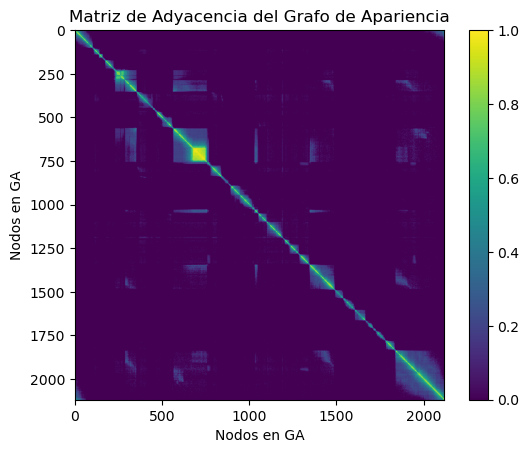

In [12]:
plt.imshow(graph.weights)
plt.colorbar()
plt.title('Adjacency matriz of the Appearance Graph')
plt.xlabel('Nodes in GA')
plt.ylabel('Nodes in GA')

Recursive Bipartition of Appearance Degree

In [13]:
clusters =graph.clusters(sup_thr=0.3)

Save Resulting Appearance Graph after bipartition

In [ ]:
map_path='.../Utils/Topological_map.json'
map = graph.create_map(map_path)

### Plot topological map and adjacency matrix by colors

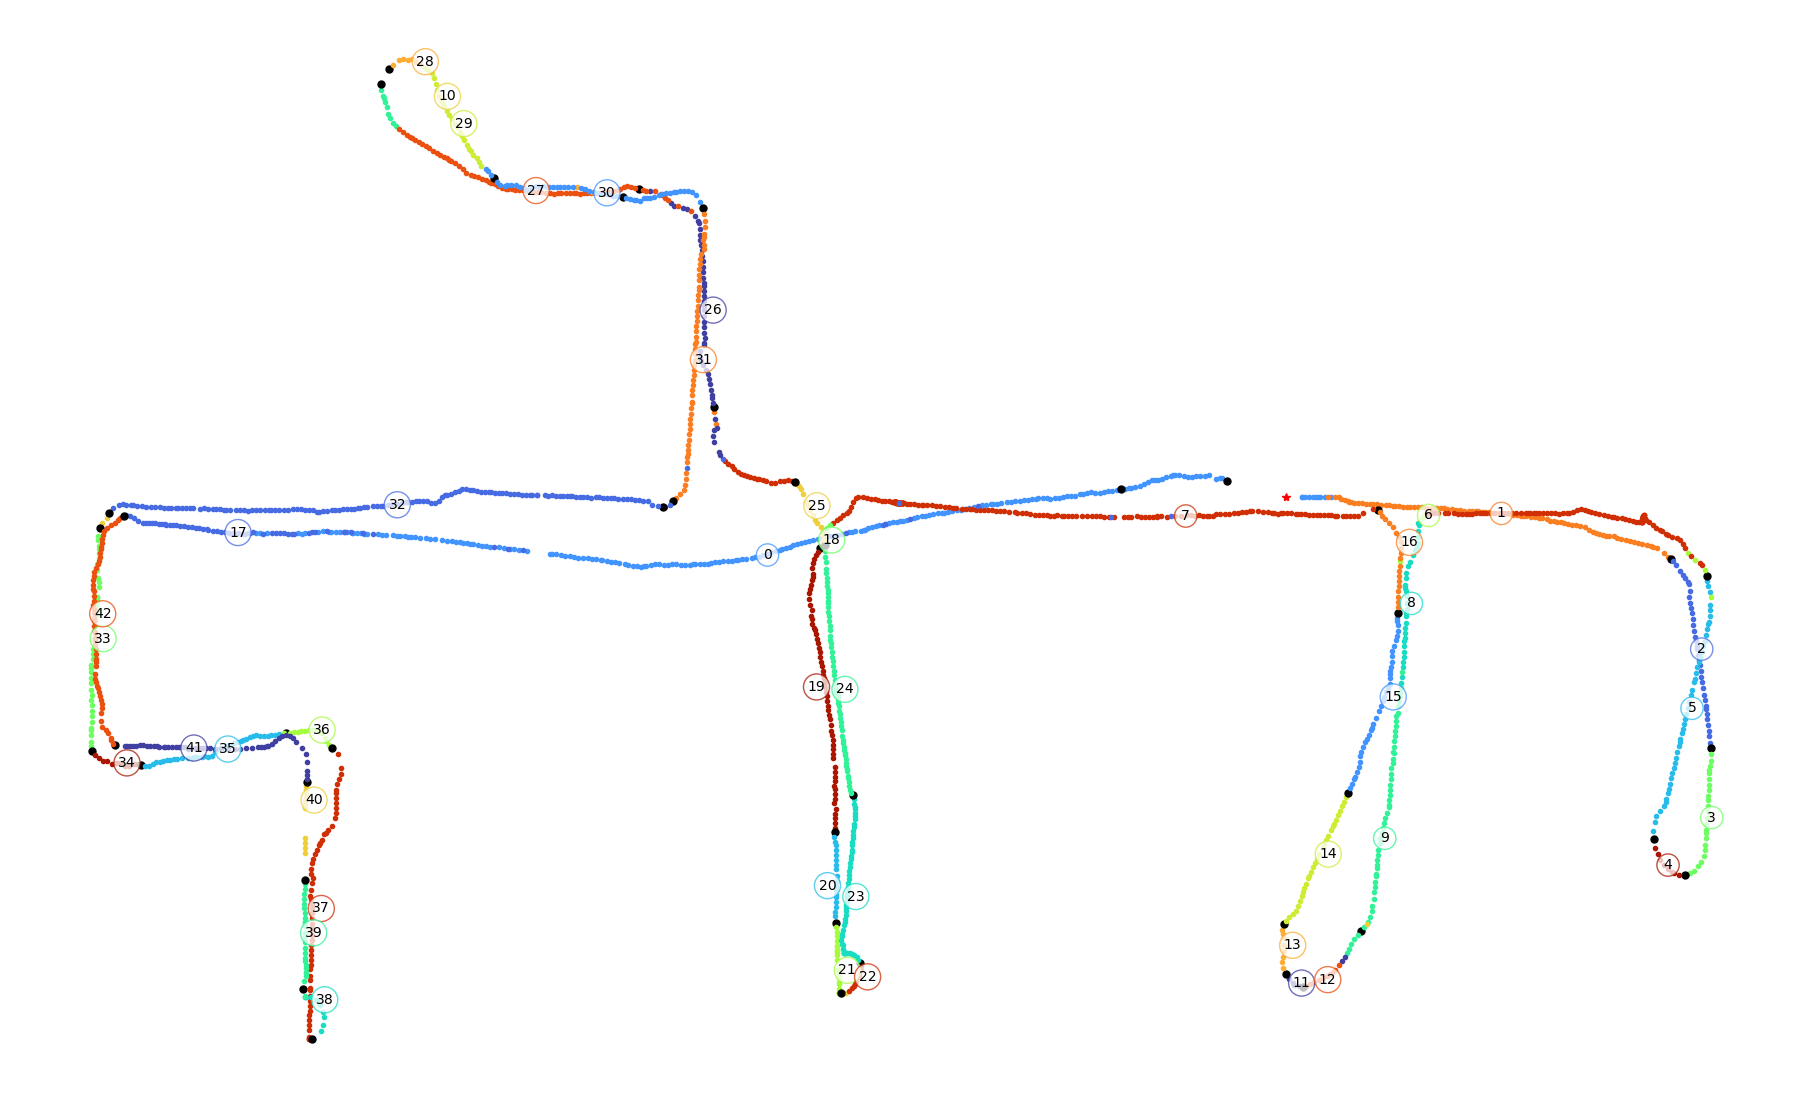

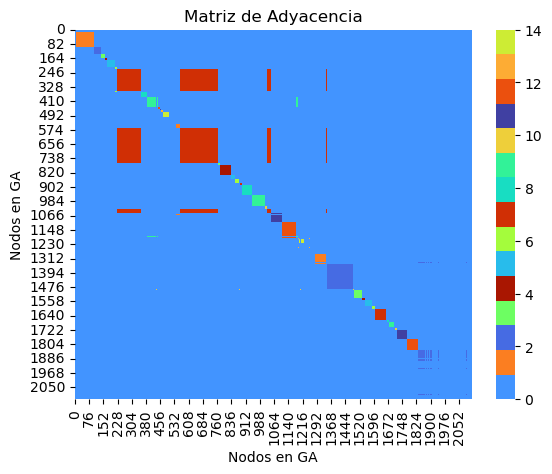

In [15]:
graph.plot_map(save=False)